In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sktime.datasets import load_airline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.pipeline import make_pipeline

In [2]:
def load_npy(filename):
    return np.load(filename)

In [3]:
import os
dir_path = 'time_series/'
len_threshold = 1280

# Prime 10 time series (random)

In [4]:
X, y, ids = [], [], []
genres = []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy': #loop su tutti i file 
        continue

    split = file.split("_")
    ids.append(split[0]) # track_id
    y.append(split[1][:-4]) # genre
    genres.append(split)
    ts = load_npy(dir_path + file)
    
    if len(ts) > len_threshold: 
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold-len(ts)) # fill with last observation 
        ts = np.append(ts, pad) 

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids) #li salvo come numpy array

In [5]:
second_elements = [item[1] for item in genres]

unique_elements = list(set([element.replace('.npy', '') for element in second_elements]))
print(unique_elements)
len(unique_elements)

['mpb', 'world-music', 'goth', 'sleep', 'heavy-metal', 'synth-pop', 'progressive-house', 'happy', 'songwriter', 'piano', 'j-idol', 'sertanejo', 'minimal-techno', 'kids', 'emo', 'new-age', 'salsa', 'opera', 'honky-tonk', 'folk']


20

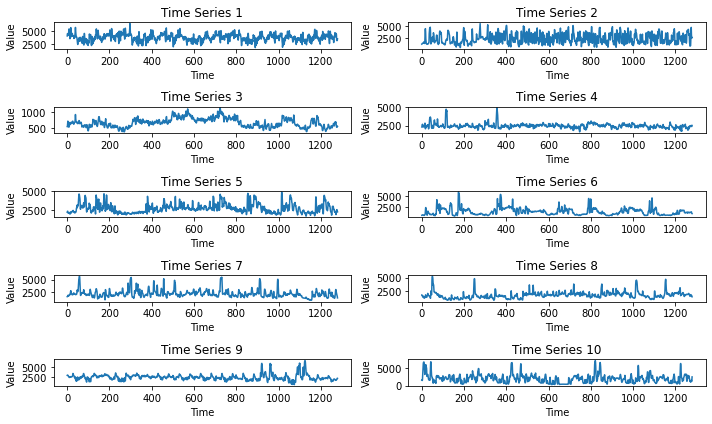

In [6]:
# Plot the first 10 time series
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(5, 2, i+1)  # 5 rows, 2 columns, i+1 is the plot index
    plt.plot(X[i][0])  # Assuming X is a list of lists where each inner list contains a single time series
    plt.title(f"Time Series {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

# Trasformazioni (amplitude scaling, noise)

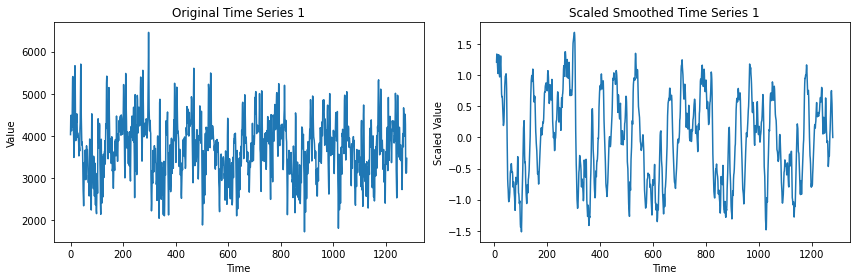

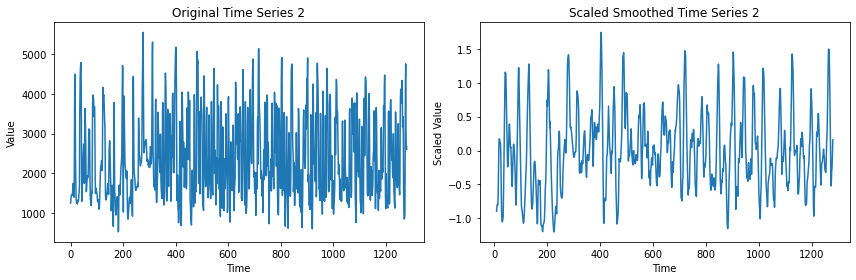

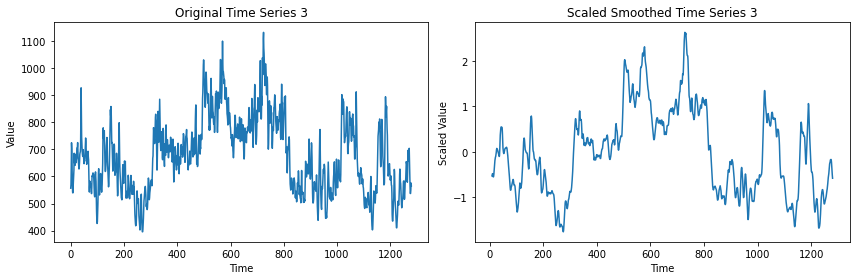

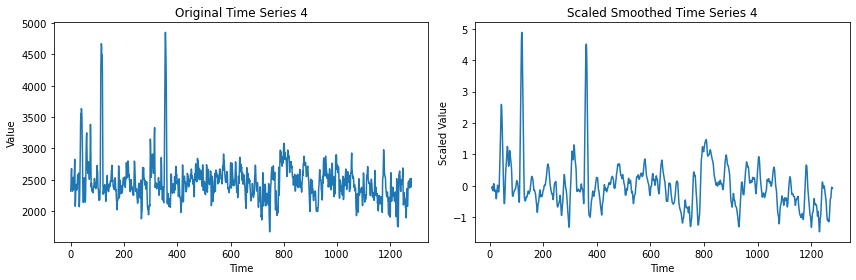

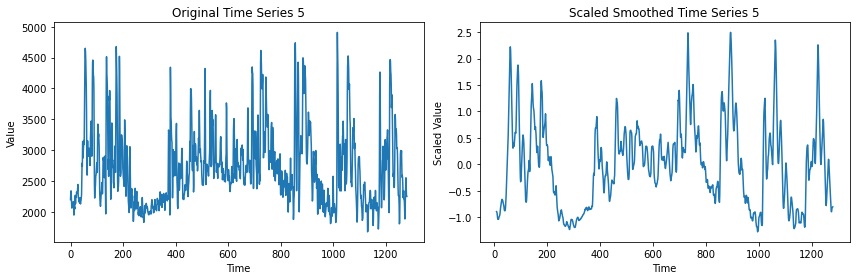

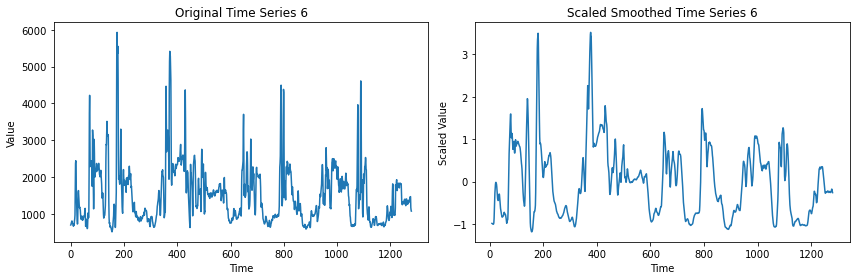

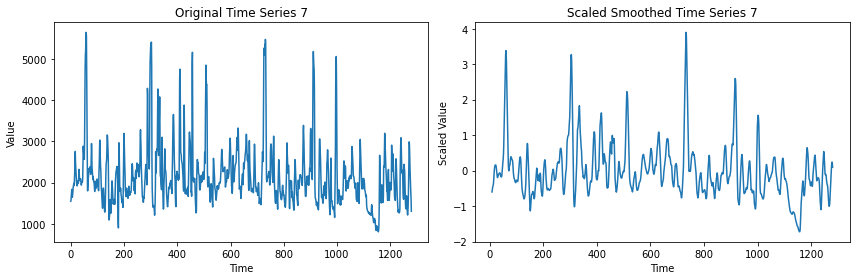

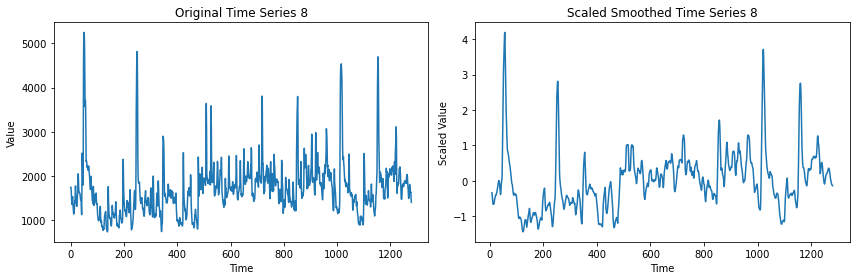

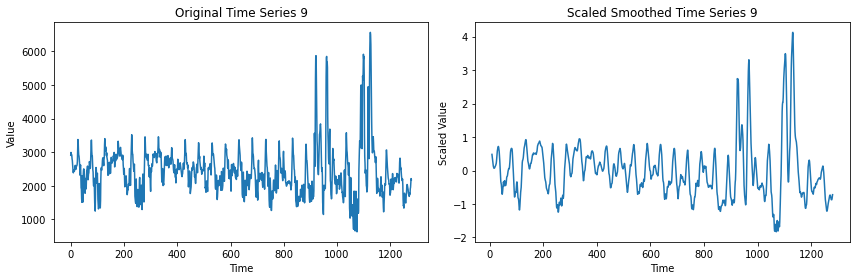

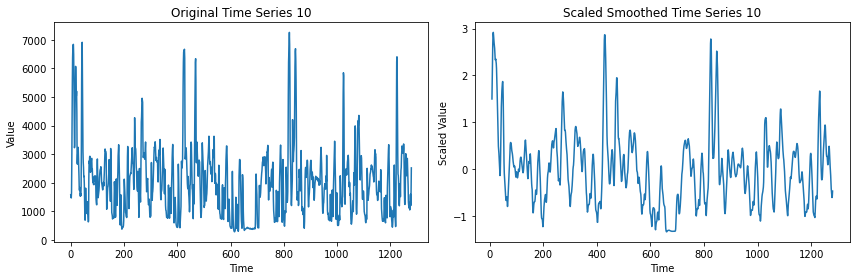

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define window size for rolling mean
w = 10

# Assume X contains the time series data for the first 10 time series
scaler = StandardScaler()

for i in range(10):
    ts = X[i][0]  # Assuming X is a list of lists where each inner list contains a single time series
    
    # Scale the time series
    tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))
    
    # Mean centering and standardization
    ts_scaled = ((tss - tss.mean()) / tss.std())
    
    # Apply rolling window mean
    ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w).mean()
    
    # Plot comparison subplot
    plt.figure(figsize=(12, 4))
    
    # Plot original time series
    plt.subplot(1, 2, 1)
    plt.plot(ts)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Original Time Series {i+1}")
    
    # Plot scaled and smoothed time series
    plt.subplot(1, 2, 2)
    plt.plot(ts_smoothed)
    plt.xlabel("Time")
    plt.ylabel("Scaled Value")
    plt.title(f"Scaled Smoothed Time Series {i+1}")
    
    plt.tight_layout()
    plt.show()


In [10]:
from sktime.transformations.panel.dictionary_based import PAA

## Approssimazione

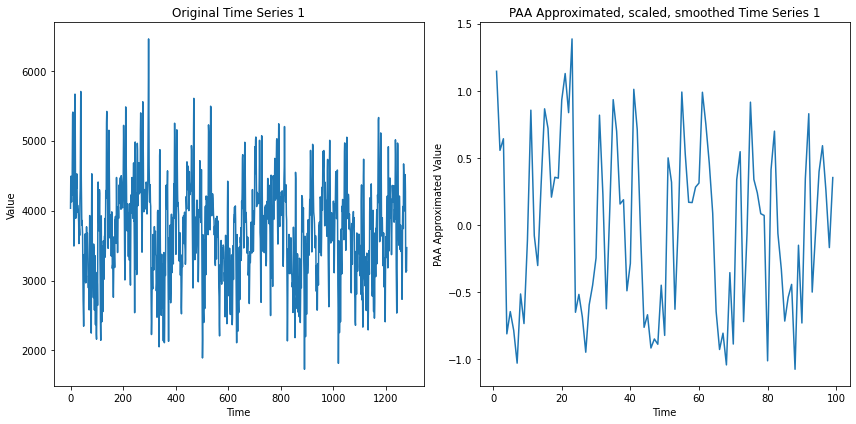

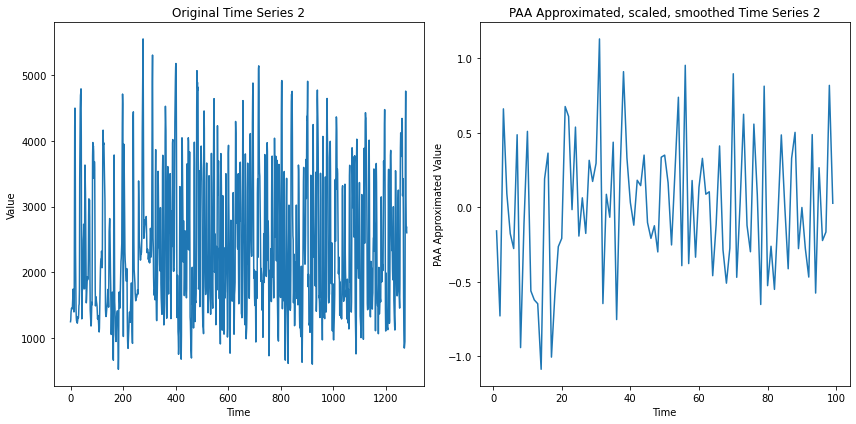

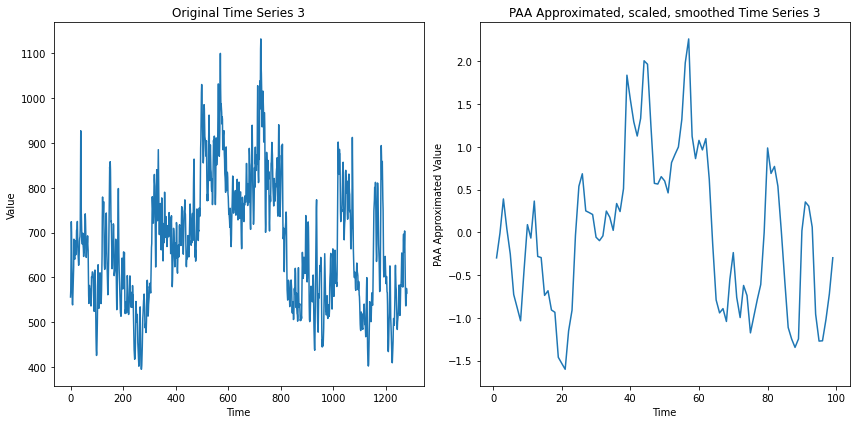

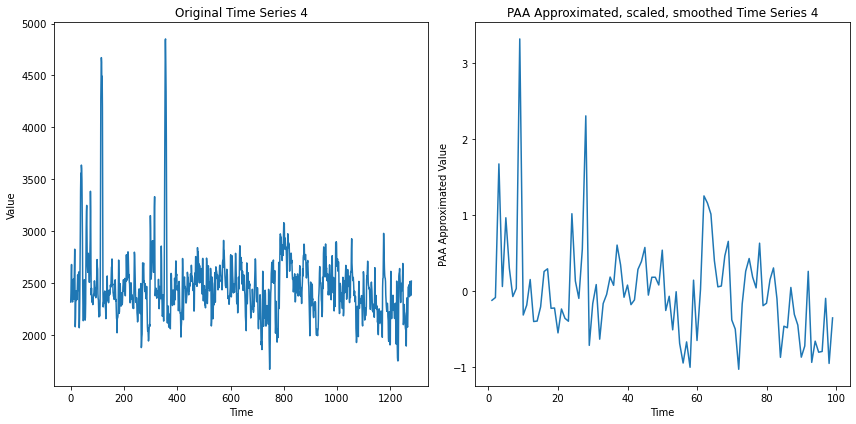

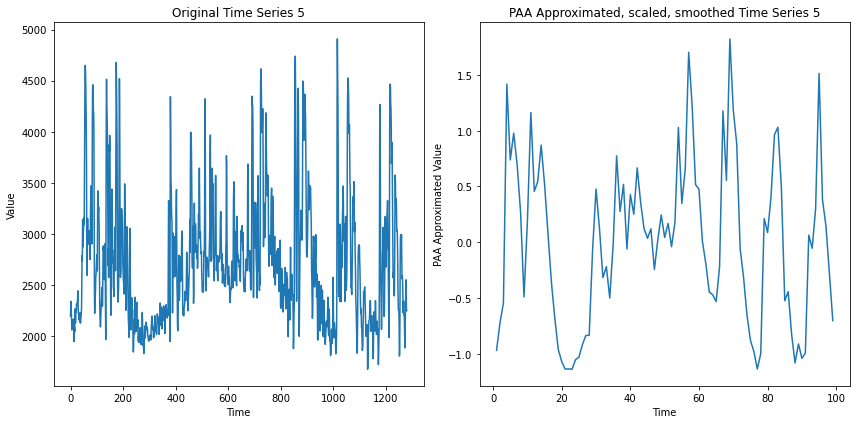

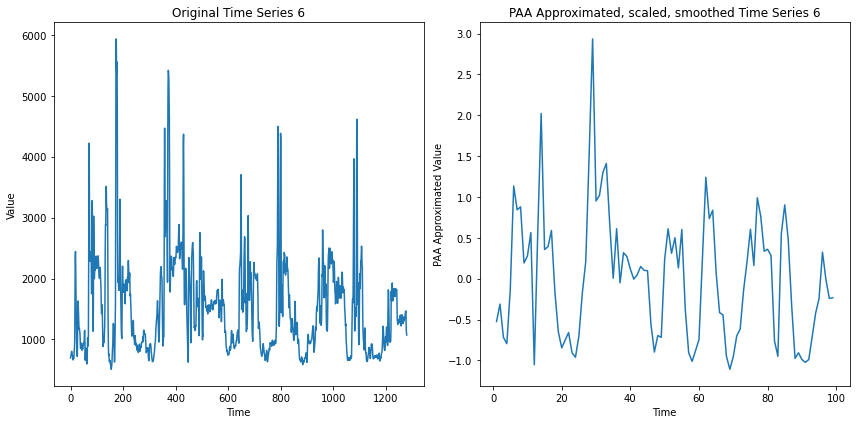

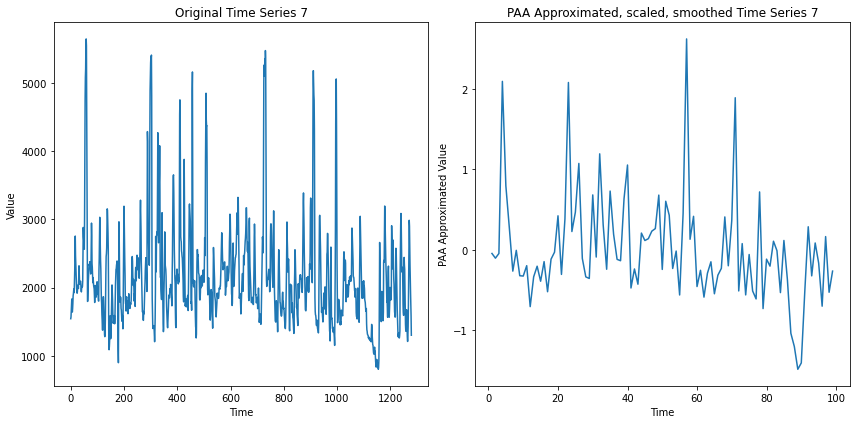

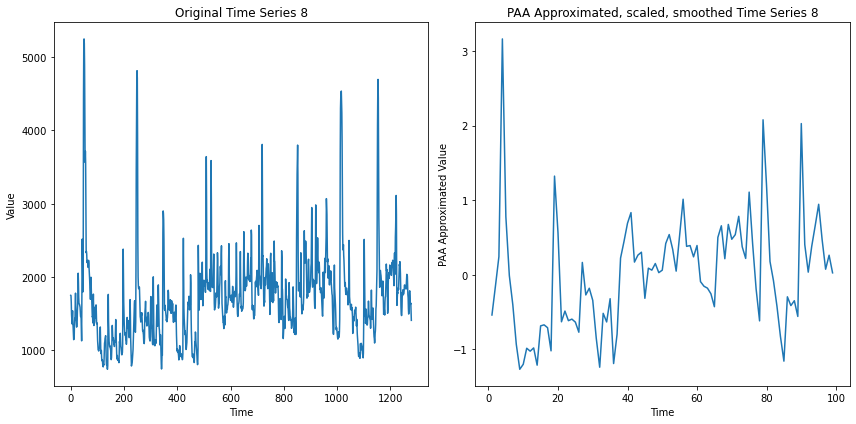

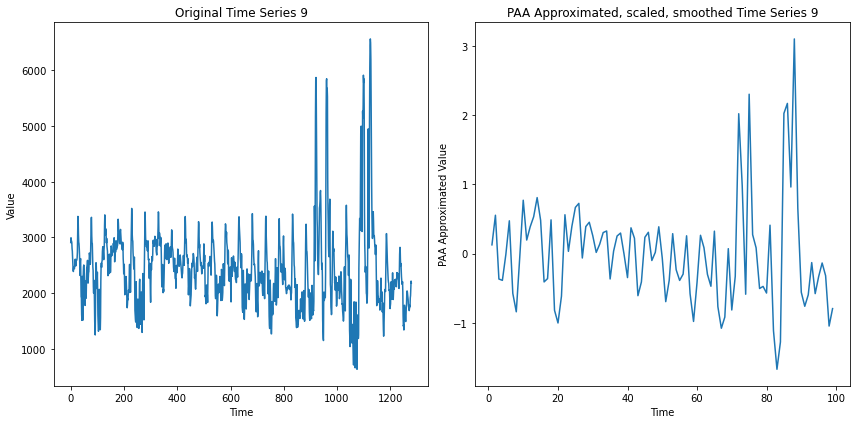

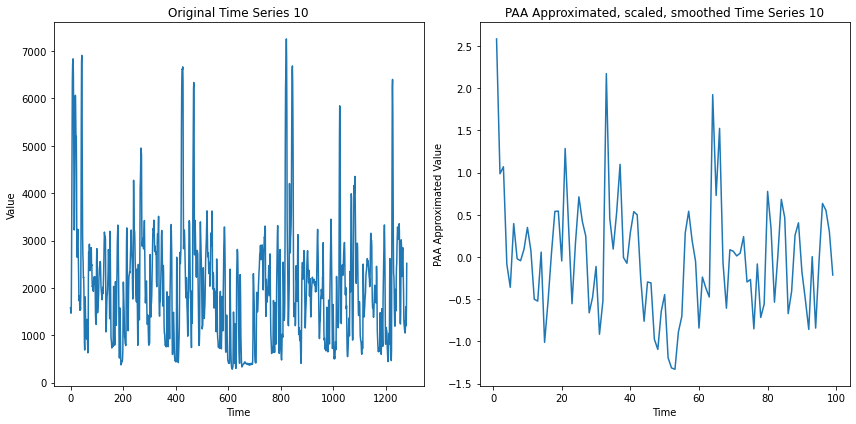

In [13]:
from sktime.transformations.panel.dictionary_based import PAA

# Define window size for rolling mean
w = 10

# Assume X contains the time series data for the first 10 time series
scaler = StandardScaler()

for i in range(10):
    ts = X[i][0]  # Assuming X is a list of lists where each inner list contains a single time series
    
    # Scale the time series
    tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))
    
    # Mean centering and standardization   (amplitude scaling)
    ts_scaled = ((tss - tss.mean()) / tss.std())
    
    # Apply rolling window mean     (noise)
    ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w).mean()
    
    # Perform Piecewise Aggregate Approximation (PAA)
    paa = PAA(num_intervals=100) # Piecewise Aggregate Approximation w. 100 intervals
    ts_paa = paa.fit_transform(pd.DataFrame(ts_smoothed)).iloc[:, 0].values
    
    # Plot comparison subplot
    plt.figure(figsize=(12, 6))
    
    # Plot original time series
    plt.subplot(1, 2, 1)
    plt.plot(ts)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Original Time Series {i+1}")
    
    # Plot PAA-approximated smoothed and scaled time series
    plt.subplot(1, 2, 2)
    plt.plot(ts_paa)
    plt.xlabel("Time")
    plt.ylabel("PAA Approximated Value")
    plt.title(f"PAA Approximated, scaled, smoothed Time Series {i+1}")
    
    plt.tight_layout()
    plt.show()
